**Context**: In this TP, we will use MedMNIST, a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. All images are pre-processed into different sizes: 28x28, 64x64, 128x128 and 256x256 with the corresponding classification labels. The size of the datasets varies from 100 to 100,000 images with different tasks, in particular: binary/multi-class.

**Goal**: Implement and use at **two**  explainability methods seen during the lecture of today (e.g., Attribution, CAM, LIME) on at least **two** different networks and **two** MedMNIST datasets (e.g., PathMNISt and DermaMNIST). You can use the image size you want (the bigger, the easier to interpret but the more computational capability you will need, please choose according to your computational capability).

**Implementation**: for complex methods ([SHAP](https://shap.readthedocs.io/en/latest/), [LRP](https://github.com/sebastian-lapuschkin/lrp_toolbox), [Integrated Gradients](https://captum.ai/docs/introduction), DeepLIFT) you can use existign implementations. See also: https://github.com/interpretml/interpret, https://github.com/marcoancona/DeepExplain,

**Deadline**: Please check on the course website.

By Nil-Dany MOSTEFAI

In [1]:
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)


try:
  import google.colab
  IN_COLAB = True
  !pip install medmnist
except:
  IN_COLAB = False

NameError: name 'os' is not defined

In [5]:
import os
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
from tqdm import trange

import medmnist
from medmnist import INFO, Evaluator

import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import quickshift

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [6]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = torch.device("cuda:0") # we use one GPU, the first one
    print ("CUDA device found.")
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.6.0+cu118
CUDA device found.


Here you can choose which dataset you want to use and the image size. Please use 28x28 at the beginning. Change the batch size according to your computational capability (1024 is good for Google Colab)

In [69]:
# Dataset Hyper-parameters
dataset_name = "pathmnist"  # Change this to any MedMNIST dataset (e.g., "chestmnist", "bloodmnist")
SIZE_IMAGES=28 # 28, 64, 128, 256
BATCH_SIZE = 1024

Here we download the data and create the datasets and loaders.

In [99]:
# Function to load any MedMNIST dataset
def load_medmnist(dataset_name, BATCH_SIZE, SIZE_IMAGES):
    info = INFO[dataset_name]
    num_classes = len(info["label"])
    in_channels = 3 if info["n_channels"] == 3 else 1  # Handle grayscale & RGB

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * in_channels, std=[0.5] * in_channels)
    ])

    DataClass = getattr(medmnist, info["python_class"])

    train_dataset = DataClass(split="train", transform=transform, download=True, size=SIZE_IMAGES)
    val_dataset = DataClass(split="val", transform=transform, download=True, size=SIZE_IMAGES)
    test_dataset = DataClass(split="test", transform=transform, download=True, size=SIZE_IMAGES)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory = True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory = True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory = True)

    task=info['task']

    return train_dataset, val_dataset, test_dataset,  train_loader, val_loader, test_loader, in_channels, num_classes, task

Here you can check the task, the number of data and verify the image size.

In [100]:
# Run training on any MedMNIST dataset
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader, in_channels, num_classes, task = load_medmnist(dataset_name, BATCH_SIZE, SIZE_IMAGES)

print('The task is', task)
# Get image size from the dataset
image_size = train_loader.dataset.imgs.shape[1]  # Works for all MedMNIST datasets
print('The size of images is ', image_size)

The task is multi-class
The size of images is  28


In [72]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/danube/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-

The authors of MedMNIST has created a function to plot the images.

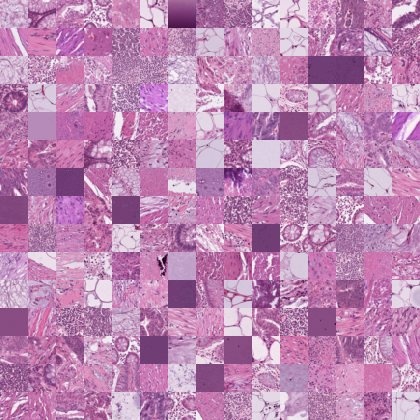

In [73]:
# montage
train_dataset.montage(length=15)

Please change the Number of epochs to 1 or 2 to test the code.

In [75]:
# Optimization Hyper-parameters
NUM_EPOCHS = 2
lr = 0.001

At first, we will use a very simple network proposed by the authors of MedMNIST. Look at it carefully. You will change it later on.

In [76]:
# define a simple CNN model (from MedMNIST website)
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


We can initalize the model and train it.

In [77]:
# Initialize model
model = Net(in_channels=in_channels, num_classes=num_classes)

**Question**: Look at the training and validation code. Why do we separate for binary and multi class ?

In [78]:
# Training Function
def train_model(model, train_loader, val_loader, task, num_epochs, lr):
    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    # Choose loss function based on the task type
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss().to(device)
    else: # multi-class
        criterion = nn.CrossEntropyLoss().to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if task == "multi-label, binary-class":
              labels = labels.to(torch.float32)  # Ensure float for BCEWithLogitsLoss
            else: # multi-class
              labels = labels.squeeze().long() # Convert one-hot to class index

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if task == "multi-label, binary-class":
                outputs = torch.sigmoid(outputs)
                predicted = (outputs >= 0.5).long()
                correct += torch.eq(predicted, labels).sum().item()
                total += labels.numel() # Nombre total d'éléments (batch_size * classes)
            else:
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
            


        accuracy = 100 * (correct / total)
        train_losses.append(running_loss / total)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/total:.4f}, Accuracy: {accuracy:.2f}%")


        # Validation phase
        model.eval()  # Set model to evaluation mode (disables dropout, batchnorm, etc.)
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # No need to compute gradients for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if task == "multi-label, binary-class":
                  labels = labels.to(torch.float32)  # Ensure float for BCEWithLogitsLoss
                else:
                  labels = labels.squeeze().long() # Convert one-hot to class index

                loss = criterion(outputs, labels)

                val_loss += loss.item() 

                if task == "multi-label, binary-class":
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs >= 0.5).long()
                    val_correct += torch.eq(predicted, labels).sum().item()
                    val_total += labels.numel()
                else:
                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)

            
        # Compute validation accuracy
        val_accuracy = 100 * (val_correct / val_total)
        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/ total:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_losses, val_accuracies


You can now train your model.

In [79]:
model = Net(in_channels=in_channels, num_classes=num_classes)

In [80]:
trained_model, train_losses, val_losses, accuracies_losses = train_model(model, train_loader, val_loader, task, NUM_EPOCHS, lr)

100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.46it/s]


Epoch 1/2, Loss: 0.0020, Accuracy: 25.34%
Epoch 1/2, Val Loss: 0.0002, Val Accuracy: 40.80%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.45it/s]


Epoch 2/2, Loss: 0.0015, Accuracy: 49.92%
Epoch 2/2, Val Loss: 0.0001, Val Accuracy: 55.10%


In [81]:
#save model checkpoints
os.makedirs('models/', exist_ok=True)
filename = 'models/ChestMNIST_'+ str(SIZE_IMAGES) +'_'+ str(NUM_EPOCHS) +'.pth.tar'
torch.save({
                'epoch': NUM_EPOCHS,
                'state_dict': trained_model.state_dict()
            }, filename)

And evaluate it.

In [96]:
# Evaluation
def evaluate(model, test_loader, task):
    model.eval()
    y_true = []  # Store true labels
    pred = []  # Store predicted classes
    test_correct = 0
    test_total = 0

    with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)

          if task == "multi-label, binary-class":
              outputs = torch.sigmoid(outputs)
              labels = labels.to(torch.float32)
              predicted = (outputs >= 0.5).long()
              test_correct += torch.eq(predicted, labels).sum().item()
              test_total += labels.numel()
          else:
              _, predicted = torch.max(outputs, 1)
              labels = labels.squeeze().long() 
              test_correct += (predicted == labels).sum().item()
              test_total += labels.size(0)

          # Collect the results
          y_true.append(labels.cpu().numpy())
          pred.append(predicted.cpu().numpy())

    # Convert to numpy arrays after gathering all results
    y_true = np.concatenate(y_true, axis=0)
    pred = np.concatenate(pred, axis=0)

    test_accuracy = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Compute test accuracy
    #acc = np.sum(y_true.flatten() == pred.flatten())/len(pred)*100
    #print(f"Test Accuracy: {acc:.2f}%")

    return y_true, pred



In [97]:
y_true,pred = evaluate(trained_model, test_loader, task)

correct_images=np.where(y_true.flatten() == pred.flatten())[0]
wrong_images=np.where(~(y_true.flatten() == pred.flatten()))[0]

Test Accuracy: 58.73%


**Question**: Train it for at least 50 epochs and look at the training/validation evolution and then at the test score. Are you satisfied ? If not, what would you change ?  

The model converges really fast, so I've trained it for only 10 epochs

In [101]:
model = Net(in_channels=in_channels, num_classes=num_classes)
NUM_EPOCHS = 50
trained_model, train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, task, NUM_EPOCHS, lr)

100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.54it/s]


Epoch 1/50, Loss: 0.0020, Accuracy: 28.01%
Epoch 1/50, Val Loss: 0.0002, Val Accuracy: 36.17%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.53it/s]


Epoch 2/50, Loss: 0.0016, Accuracy: 46.01%
Epoch 2/50, Val Loss: 0.0002, Val Accuracy: 50.28%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.56it/s]


Epoch 3/50, Loss: 0.0012, Accuracy: 55.47%
Epoch 3/50, Val Loss: 0.0001, Val Accuracy: 59.11%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.54it/s]


Epoch 4/50, Loss: 0.0009, Accuracy: 63.97%
Epoch 4/50, Val Loss: 0.0001, Val Accuracy: 65.52%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.51it/s]


Epoch 5/50, Loss: 0.0008, Accuracy: 68.98%
Epoch 5/50, Val Loss: 0.0001, Val Accuracy: 69.83%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.60it/s]


Epoch 6/50, Loss: 0.0007, Accuracy: 73.14%
Epoch 6/50, Val Loss: 0.0001, Val Accuracy: 73.03%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.55it/s]


Epoch 7/50, Loss: 0.0006, Accuracy: 76.20%
Epoch 7/50, Val Loss: 0.0001, Val Accuracy: 76.10%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.51it/s]


Epoch 8/50, Loss: 0.0006, Accuracy: 78.21%
Epoch 8/50, Val Loss: 0.0001, Val Accuracy: 77.76%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.56it/s]


Epoch 9/50, Loss: 0.0005, Accuracy: 80.09%
Epoch 9/50, Val Loss: 0.0001, Val Accuracy: 79.19%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.56it/s]


Epoch 10/50, Loss: 0.0005, Accuracy: 81.44%
Epoch 10/50, Val Loss: 0.0001, Val Accuracy: 79.39%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.57it/s]


Epoch 11/50, Loss: 0.0005, Accuracy: 82.69%
Epoch 11/50, Val Loss: 0.0001, Val Accuracy: 81.16%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


Epoch 12/50, Loss: 0.0004, Accuracy: 83.74%
Epoch 12/50, Val Loss: 0.0001, Val Accuracy: 82.30%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


Epoch 13/50, Loss: 0.0004, Accuracy: 84.62%
Epoch 13/50, Val Loss: 0.0001, Val Accuracy: 81.19%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


Epoch 14/50, Loss: 0.0004, Accuracy: 85.65%
Epoch 14/50, Val Loss: 0.0001, Val Accuracy: 83.29%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


Epoch 15/50, Loss: 0.0004, Accuracy: 86.10%
Epoch 15/50, Val Loss: 0.0001, Val Accuracy: 83.03%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.56it/s]


Epoch 16/50, Loss: 0.0004, Accuracy: 86.75%
Epoch 16/50, Val Loss: 0.0001, Val Accuracy: 79.58%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.57it/s]


Epoch 17/50, Loss: 0.0003, Accuracy: 87.64%
Epoch 17/50, Val Loss: 0.0000, Val Accuracy: 86.67%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.57it/s]


Epoch 18/50, Loss: 0.0003, Accuracy: 88.27%
Epoch 18/50, Val Loss: 0.0000, Val Accuracy: 86.98%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.59it/s]


Epoch 19/50, Loss: 0.0003, Accuracy: 88.60%
Epoch 19/50, Val Loss: 0.0001, Val Accuracy: 80.72%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.55it/s]


Epoch 20/50, Loss: 0.0003, Accuracy: 89.08%
Epoch 20/50, Val Loss: 0.0000, Val Accuracy: 85.42%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.59it/s]


Epoch 21/50, Loss: 0.0003, Accuracy: 89.48%
Epoch 21/50, Val Loss: 0.0000, Val Accuracy: 86.76%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.56it/s]


Epoch 22/50, Loss: 0.0003, Accuracy: 89.90%
Epoch 22/50, Val Loss: 0.0000, Val Accuracy: 84.49%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


Epoch 23/50, Loss: 0.0003, Accuracy: 90.16%
Epoch 23/50, Val Loss: 0.0000, Val Accuracy: 87.90%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.57it/s]


Epoch 24/50, Loss: 0.0003, Accuracy: 90.57%
Epoch 24/50, Val Loss: 0.0000, Val Accuracy: 88.51%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.59it/s]


Epoch 25/50, Loss: 0.0003, Accuracy: 90.82%
Epoch 25/50, Val Loss: 0.0000, Val Accuracy: 88.66%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.55it/s]


Epoch 26/50, Loss: 0.0002, Accuracy: 91.26%
Epoch 26/50, Val Loss: 0.0000, Val Accuracy: 89.45%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


Epoch 27/50, Loss: 0.0002, Accuracy: 91.31%
Epoch 27/50, Val Loss: 0.0000, Val Accuracy: 89.40%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.56it/s]


Epoch 28/50, Loss: 0.0002, Accuracy: 91.58%
Epoch 28/50, Val Loss: 0.0001, Val Accuracy: 84.52%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.58it/s]


Epoch 29/50, Loss: 0.0002, Accuracy: 92.01%
Epoch 29/50, Val Loss: 0.0000, Val Accuracy: 90.23%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.59it/s]


Epoch 30/50, Loss: 0.0002, Accuracy: 92.01%
Epoch 30/50, Val Loss: 0.0000, Val Accuracy: 86.79%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.60it/s]


Epoch 31/50, Loss: 0.0002, Accuracy: 92.48%
Epoch 31/50, Val Loss: 0.0000, Val Accuracy: 88.86%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.59it/s]


Epoch 32/50, Loss: 0.0002, Accuracy: 92.61%
Epoch 32/50, Val Loss: 0.0000, Val Accuracy: 90.09%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.55it/s]


Epoch 33/50, Loss: 0.0002, Accuracy: 92.75%
Epoch 33/50, Val Loss: 0.0000, Val Accuracy: 87.50%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.64it/s]


Epoch 34/50, Loss: 0.0002, Accuracy: 92.78%
Epoch 34/50, Val Loss: 0.0000, Val Accuracy: 89.47%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:33<00:00,  2.62it/s]


Epoch 35/50, Loss: 0.0002, Accuracy: 93.09%
Epoch 35/50, Val Loss: 0.0001, Val Accuracy: 83.40%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.53it/s]


Epoch 36/50, Loss: 0.0002, Accuracy: 93.32%
Epoch 36/50, Val Loss: 0.0000, Val Accuracy: 89.41%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.54it/s]


Epoch 37/50, Loss: 0.0002, Accuracy: 93.36%
Epoch 37/50, Val Loss: 0.0000, Val Accuracy: 88.24%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.53it/s]


Epoch 38/50, Loss: 0.0002, Accuracy: 93.69%
Epoch 38/50, Val Loss: 0.0000, Val Accuracy: 89.88%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.54it/s]


Epoch 39/50, Loss: 0.0002, Accuracy: 93.93%
Epoch 39/50, Val Loss: 0.0000, Val Accuracy: 91.76%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.51it/s]


Epoch 40/50, Loss: 0.0002, Accuracy: 94.04%
Epoch 40/50, Val Loss: 0.0000, Val Accuracy: 88.73%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.50it/s]


Epoch 41/50, Loss: 0.0002, Accuracy: 94.10%
Epoch 41/50, Val Loss: 0.0000, Val Accuracy: 90.57%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.51it/s]


Epoch 42/50, Loss: 0.0002, Accuracy: 94.27%
Epoch 42/50, Val Loss: 0.0000, Val Accuracy: 91.28%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.53it/s]


Epoch 43/50, Loss: 0.0002, Accuracy: 94.33%
Epoch 43/50, Val Loss: 0.0000, Val Accuracy: 90.61%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.49it/s]


Epoch 44/50, Loss: 0.0002, Accuracy: 94.42%
Epoch 44/50, Val Loss: 0.0000, Val Accuracy: 92.32%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.53it/s]


Epoch 45/50, Loss: 0.0002, Accuracy: 94.64%
Epoch 45/50, Val Loss: 0.0000, Val Accuracy: 92.22%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.50it/s]


Epoch 46/50, Loss: 0.0001, Accuracy: 94.77%
Epoch 46/50, Val Loss: 0.0000, Val Accuracy: 88.72%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:35<00:00,  2.50it/s]


Epoch 47/50, Loss: 0.0001, Accuracy: 94.83%
Epoch 47/50, Val Loss: 0.0000, Val Accuracy: 88.01%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.52it/s]


Epoch 48/50, Loss: 0.0001, Accuracy: 94.83%
Epoch 48/50, Val Loss: 0.0000, Val Accuracy: 91.09%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.52it/s]


Epoch 49/50, Loss: 0.0001, Accuracy: 95.08%
Epoch 49/50, Val Loss: 0.0000, Val Accuracy: 86.09%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [00:34<00:00,  2.51it/s]


Epoch 50/50, Loss: 0.0001, Accuracy: 95.21%
Epoch 50/50, Val Loss: 0.0000, Val Accuracy: 93.12%


Let's look at some correctly classified and wrongly classified images.

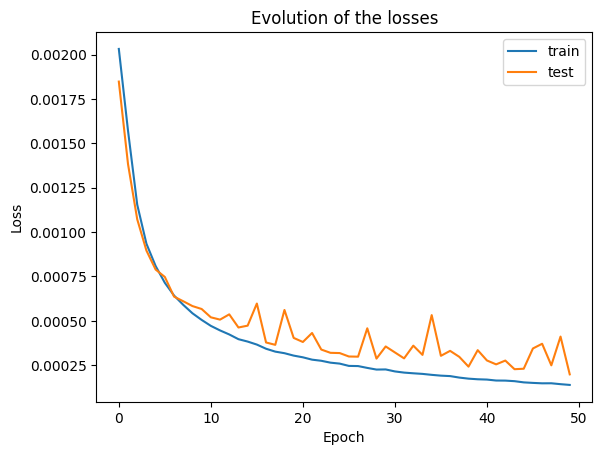

/tmp/ipykernel_298882/3276916997.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


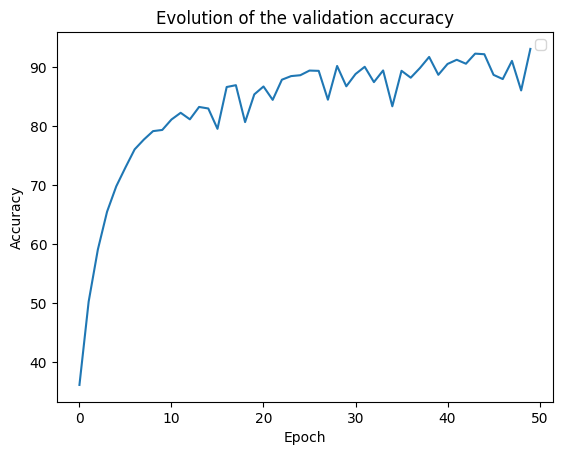

In [106]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of the losses")
plt.plot(train_losses, label = "train")
plt.plot(val_losses, label = "test")
plt.legend()
plt.show()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolution of the validation accuracy")
plt.plot(val_accuracies)
plt.legend()
plt.show()

We have reached a very good accuracy, and we stopped before the model overfits too much.

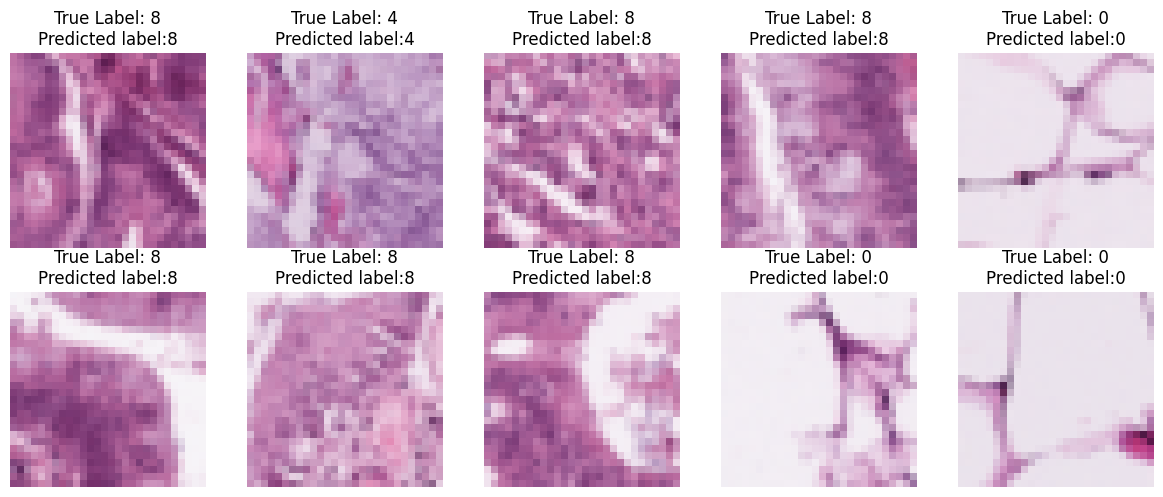

In [107]:
# Correctly classified
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

selected_indices = correct_images[:10]

# Iterate through the selected indices
for i, idx in enumerate(selected_indices):
    image, label = test_loader.dataset[idx]  # Extract image and label

    # If image is RGB, swap dimensions from (C, H, W) to (H, W, C)
    mean=torch.tensor([.5])
    std=torch.tensor([.5])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img = np.clip(unnormalize(image).numpy(),0,1)
    img = img.transpose(1, 2, 0)  # Convert from PyTorch format to Matplotlib format

    axes[i].imshow(img)  # Adjust cmap if necessary
    axes[i].set_title(f"True Label: {label[0]}\nPredicted label:{pred[idx]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

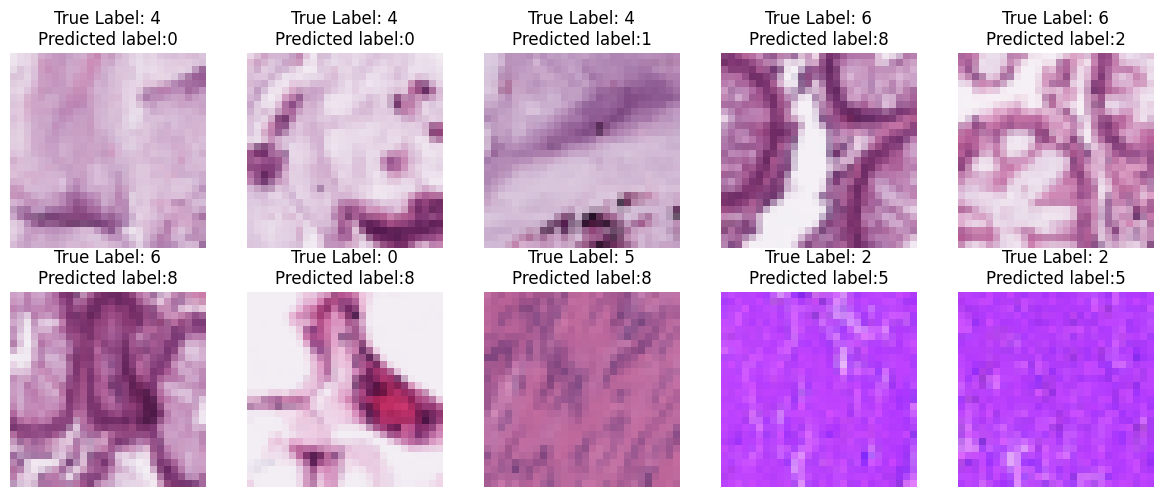

In [108]:
# Wrongly classified
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

selected_indices = wrong_images[:10]

# Iterate through the selected indices
for i, idx in enumerate(selected_indices):
    image, label = test_loader.dataset[idx]  # Extract image and label

    # If image is RGB, swap dimensions from (C, H, W) to (H, W, C)
    mean=torch.tensor([.5])
    std=torch.tensor([.5])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img = np.clip(unnormalize(image).numpy(),0,1)
    img = img.transpose(1, 2, 0)  # Convert from PyTorch format to Matplotlib format

    axes[i].imshow(img)  # Adjust cmap if necessary
    axes[i].set_title(f"True Label: {label[0]}\nPredicted label:{pred[idx]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

**Question**: Can you see some patterns that could explain why the algorithm has wrongly classified these images ? At the lowest resolution (28x28) is very difficult (I would say impossible). Choose a higher resolution and train the same code.

The model seems to be biased towards predicting label 8 when he doesn't know (See the 3 first images in the second row). He predicted label 0 for images that are label 4, which is quite understandable since the images are low resolution, and the two labels have a lot in common (same color, same red structures). Also, notice how he fails at predicting label 5 in the third-to-last image, and he predicts label 5 for the label 2 images. Label 5 images and label 2 images seems to share the same texture (but different color) and that's why the model has failed.

Notice also that the image with true label 0 hasn't been predicted as 0 because the proeminent red structure in it.

**Question**: You probably found an error. Please change the `Net` code so that it can work with any input size. If you want to speed up computations, you can also change the number of channels. You can also change the optimization process if you wish.

In [137]:
# Run training on any MedMNIST dataset
SIZE_IMAGES = 64
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader, in_channels, num_classes, task = load_medmnist(dataset_name, BATCH_SIZE, SIZE_IMAGES)

print('The task is', task)
# Get image size from the dataset
image_size = train_loader.dataset.imgs.shape[1]  # Works for all MedMNIST datasets
print('The size of images is ', image_size)

The task is multi-class
The size of images is  64


In [138]:
# define a simple CNN model (from MedMNIST website)
class Net64(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net64, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 13 * 13, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [142]:
model = Net64(in_channels=in_channels, num_classes=num_classes).to(device)
NUM_EPOCHS = 10
trained_model, train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, task, NUM_EPOCHS, lr)

100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:12<00:00,  1.51s/it]


Epoch 1/10, Loss: 0.0016, Accuracy: 42.89%
Epoch 1/10, Val Loss: 0.0001, Val Accuracy: 61.38%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:20<00:00,  1.60s/it]


Epoch 2/10, Loss: 0.0008, Accuracy: 70.30%
Epoch 2/10, Val Loss: 0.0001, Val Accuracy: 74.66%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:24<00:00,  1.65s/it]


Epoch 3/10, Loss: 0.0006, Accuracy: 77.45%
Epoch 3/10, Val Loss: 0.0001, Val Accuracy: 76.72%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:28<00:00,  1.68s/it]


Epoch 4/10, Loss: 0.0005, Accuracy: 81.85%
Epoch 4/10, Val Loss: 0.0001, Val Accuracy: 82.63%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:27<00:00,  1.68s/it]


Epoch 5/10, Loss: 0.0004, Accuracy: 84.82%
Epoch 5/10, Val Loss: 0.0000, Val Accuracy: 85.92%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:22<00:00,  1.62s/it]


Epoch 6/10, Loss: 0.0004, Accuracy: 87.30%
Epoch 6/10, Val Loss: 0.0000, Val Accuracy: 86.17%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:18<00:00,  1.57s/it]


Epoch 7/10, Loss: 0.0003, Accuracy: 89.19%
Epoch 7/10, Val Loss: 0.0000, Val Accuracy: 84.07%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:23<00:00,  1.63s/it]


Epoch 8/10, Loss: 0.0003, Accuracy: 90.61%
Epoch 8/10, Val Loss: 0.0000, Val Accuracy: 89.03%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:17<00:00,  1.57s/it]


Epoch 9/10, Loss: 0.0002, Accuracy: 91.78%
Epoch 9/10, Val Loss: 0.0000, Val Accuracy: 90.21%


100%|███████████████████████████████████████████████████████████████████████████████████| 88/88 [02:18<00:00,  1.57s/it]


Epoch 10/10, Loss: 0.0002, Accuracy: 92.41%
Epoch 10/10, Val Loss: 0.0000, Val Accuracy: 90.81%


In [145]:
torch.save( trained_model.state_dict(), "Model64.pth",)

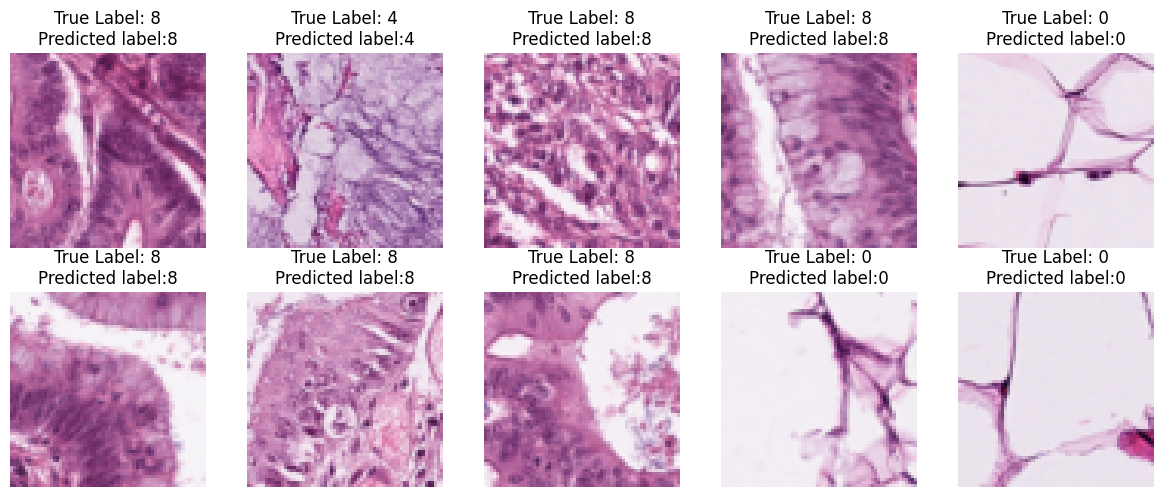

In [147]:
# Correctly classified
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

selected_indices = correct_images[:10]

# Iterate through the selected indices
for i, idx in enumerate(selected_indices):
    image, label = test_loader.dataset[idx]  # Extract image and label

    # If image is RGB, swap dimensions from (C, H, W) to (H, W, C)
    mean=torch.tensor([.5])
    std=torch.tensor([.5])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img = np.clip(unnormalize(image).numpy(),0,1)
    img = img.transpose(1, 2, 0)  # Convert from PyTorch format to Matplotlib format

    axes[i].imshow(img)  # Adjust cmap if necessary
    axes[i].set_title(f"True Label: {label[0]}\nPredicted label:{pred[idx]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

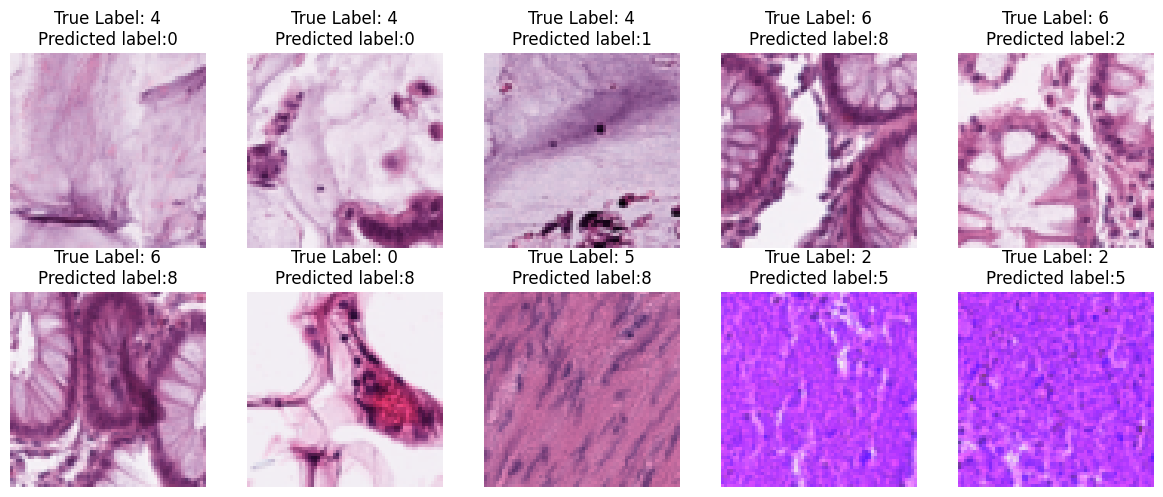

In [146]:
# Wrongly classified
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

selected_indices = wrong_images[:10]

# Iterate through the selected indices
for i, idx in enumerate(selected_indices):
    image, label = test_loader.dataset[idx]  # Extract image and label

    # If image is RGB, swap dimensions from (C, H, W) to (H, W, C)
    mean=torch.tensor([.5])
    std=torch.tensor([.5])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img = np.clip(unnormalize(image).numpy(),0,1)
    img = img.transpose(1, 2, 0)  # Convert from PyTorch format to Matplotlib format

    axes[i].imshow(img)  # Adjust cmap if necessary
    axes[i].set_title(f"True Label: {label[0]}\nPredicted label:{pred[idx]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

The fourth image is intersting, the white gap between the two red structures seems to have pushed the model into believing that it's class 8.

**Question**: Now that you have a working code. Implement and use at **two**  explainability methods seen during the lecture of today (e.g., Attribution, CAM, LIME) on at least **two** different networks and **two** MedMNIST datasets (e.g., PathMNISt and DermaMNIST). You can use the image size you want (the bigger, the easier to interpret but the more computational capability you will need, please choose according to your computational capability).
As network, you can use the modified `Net`and either a pre-trained Pytorch one (such as ResNet) or another custom one of your choice.

## GRADCAM

For the first explainability method, I've decided to implement GradCAM : [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391).

GradCAM is easy to implement, and provide good insight about where a layer of the CNN network puts its attention.
It is based on the gradient of the output wrto an activation layer.




In [166]:
def Grad_CAM(label, image, conv_layer ):
    """
    Computes the heatmap showing where the network is focused.
    ---Args:
        - label (int or str) : the corresponding index of the label, or the name of the label.
        - image (tensor) : the image to process.
        - conv_layer (Conv2d) : the layer that we'll use to get the semantic output (in the paper, it's the last convolutional layer).
    """
    # In case label is the name, we'll retrieve the corresponding index
    if isinstance(label, str):
        label = rev_classes[label]
    
    
    feature_map = []
    # Put the intermediate feature map outputed by module in feature_map list
    def forward_hook(module, inputs, outputs):
        feature_map.append(outputs)

    handle = conv_layer.register_forward_hook(forward_hook)
    output = model(image)[0]
    handle.remove()
    # Feature_map yielded by the conv_layer
    feature_map = feature_map[0]
    # We'll compute the derivative of the output for the corresponding label wrto the feature map
    feature_map.retain_grad()
    output[label].backward()
    gradient = feature_map.grad
    # As seen in the paper, the coefficients alpha are the coefficients we use to weights the feature maps.
    alpha = torch.mean(gradient, axis = [2, 3])
    alpha = alpha[:, :, None, None]
    # We merge all the features maps with their corresponding weights and then use ReLU
    heatmap = torch.sum(alpha * feature_map, axis = [ 1]) 
    heatmap = nn.ReLU()(heatmap).unsqueeze(1)
    # Bilinear interpolation to get an image of the same size as the input image
    heatmap = nn.functional.interpolate(heatmap, [64, 64], mode = "bilinear").squeeze(1)
    return heatmap.detach().numpy()


In [153]:
trained_model.layer5[0]

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [156]:
trained_model = trained_model.to("cpu")

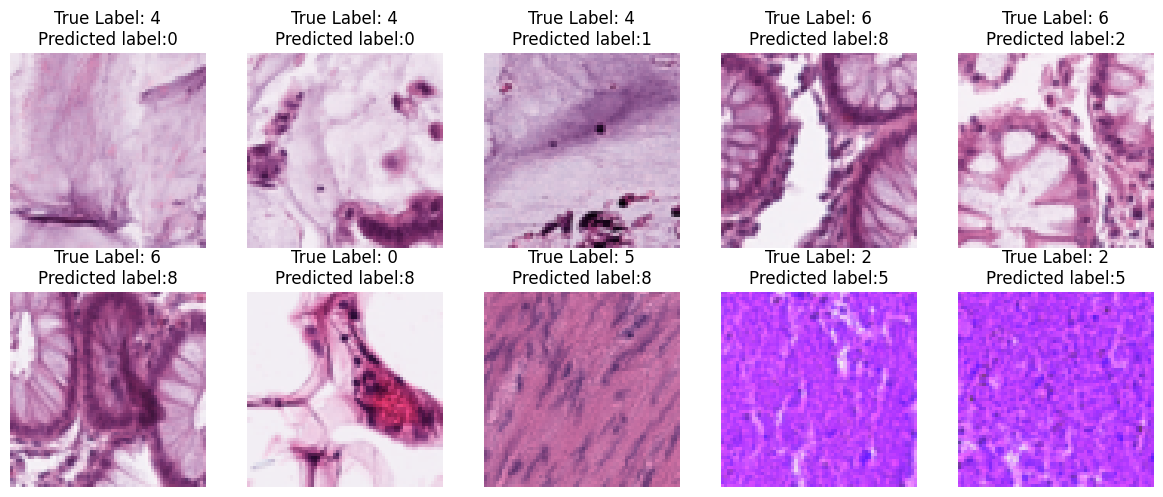

In [174]:
# Wrongly classified
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

selected_indices = wrong_images[:10]

# Iterate through the selected indices
for i, idx in enumerate(selected_indices):
    image, label = test_loader.dataset[idx]  # Extract image and label

    # If image is RGB, swap dimensions from (C, H, W) to (H, W, C)
    mean=torch.tensor([.5])
    std=torch.tensor([.5])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img = np.clip(unnormalize(image).numpy(),0,1)
    img = img.transpose(1, 2, 0)  # Convert from PyTorch format to Matplotlib format

    axes[i].imshow(img)  # Adjust cmap if necessary
    axes[i].set_title(f"True Label: {label[0]}\nPredicted label:{pred[idx]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

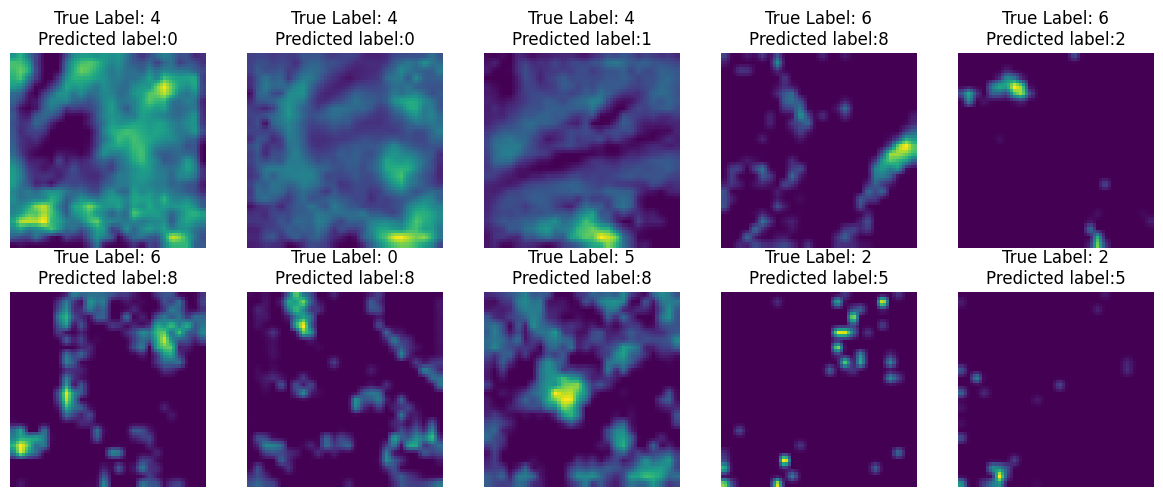

In [173]:

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

selected_indices = wrong_images[:10]

# Iterate through the selected indices
for i, idx in enumerate(selected_indices):
    image, label = test_loader.dataset[idx]  # Extract image and label

    # If image is RGB, swap dimensions from (C, H, W) to (H, W, C)
    mean=torch.tensor([.5])
    std=torch.tensor([.5])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    img = np.clip(unnormalize(image).numpy(),0,1)
    img = img.transpose(1, 2, 0)  # Convert from PyTorch format to Matplotlib format
    output = Grad_CAM(pred[idx], image.unsqueeze(0), trained_model.layer5[0])
    axes[i].imshow(img)  # Adjust cmap if necessary
    axes[i].imshow(output.transpose(1, 2, 0))
    axes[i].set_title(f"True Label: {label[0]}\nPredicted label:{pred[idx]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

The corresponding images show the regions that pushed the model to make those predictions.

For instance, the fourth heatmap is in line with what i've said before : the white gap is highlighted in green (meaning it has played a role in the prediction), and most importantly, the contour of the right cell has the greatest activation.

Notice also how for the two last images, the layer is focused on very small details (which are the small white gaps in the fluid).

Globally, we can clearly see that this layer is focused on high level structures such as the red cells and the gaps between those cells.



## Activation maximization

In [201]:
from tqdm import tqdm
def activation_maximization(model, layer_idx, filter_idx, lr = 0.01, n_iters = 1000, tau = 1e-3):
    X = torch.randn(1, 3, SIZE_IMAGES, SIZE_IMAGES).requires_grad_(True)
    optimizer = optim.Adam([X], lr = lr)
    target_layer = list(model.children())[layer_idx][0]
    print(target_layer)
    losses = []
    for i in tqdm(range(n_iters)):
        model.zero_grad()
        activations = {}
        def hook_fn(module, input, output):
            activations["output"] = output
        hook = target_layer.register_forward_hook(hook_fn)
        _ = model(X)
        hook.remove()
        activations = activations["output"] 
        # Define loss as negative activation of the target filter
        loss = -torch.mean(activations[0, filter_idx])
        loss += tau * torch.norm(X)
        loss.backward()
        losses.append(loss.item())
        # Update the image to maximize activation
        optimizer.step()
        
        # Optional: Clip values to valid image range [0, 1]
        X.data = torch.clamp(X.data, 0, 1)
    img = X.detach().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img, losses

In [215]:
img, losses = activation_maximization(model, 4, 0, lr = 1, n_iters = 1000, tau = 1e-3)

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


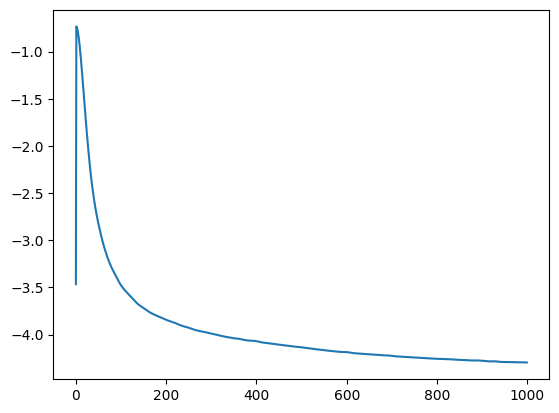

In [216]:
plt.plot(losses)

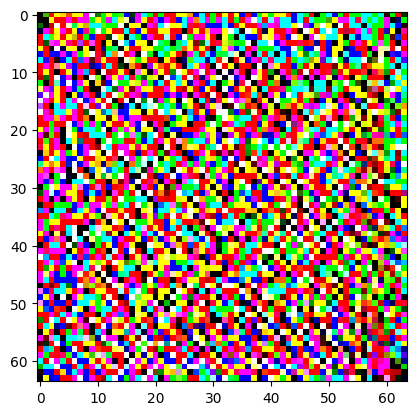

In [217]:
plt.imshow(img)

Activation maximization doesn't seem to be effective for this dataset. Also, the problem may come from the implementation.

In [220]:
dataset_name = "bloodmnist"  # Change this to any MedMNIST dataset (e.g., "chestmnist", "bloodmnist")
SIZE_IMAGES=64 # 28, 64, 128, 256
BATCH_SIZE = 1024

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader, in_channels, num_classes, task = load_medmnist(dataset_name, BATCH_SIZE, SIZE_IMAGES)

print('The task is', task)
# Get image size from the dataset
image_size = train_loader.dataset.imgs.shape[1]  # Works for all MedMNIST datasets
print('The size of images is ', image_size)

100%|████████████████████████████████████████████████████████████████████████████████| 156M/156M [00:08<00:00, 17.6MB/s]


The task is multi-class
The size of images is  64


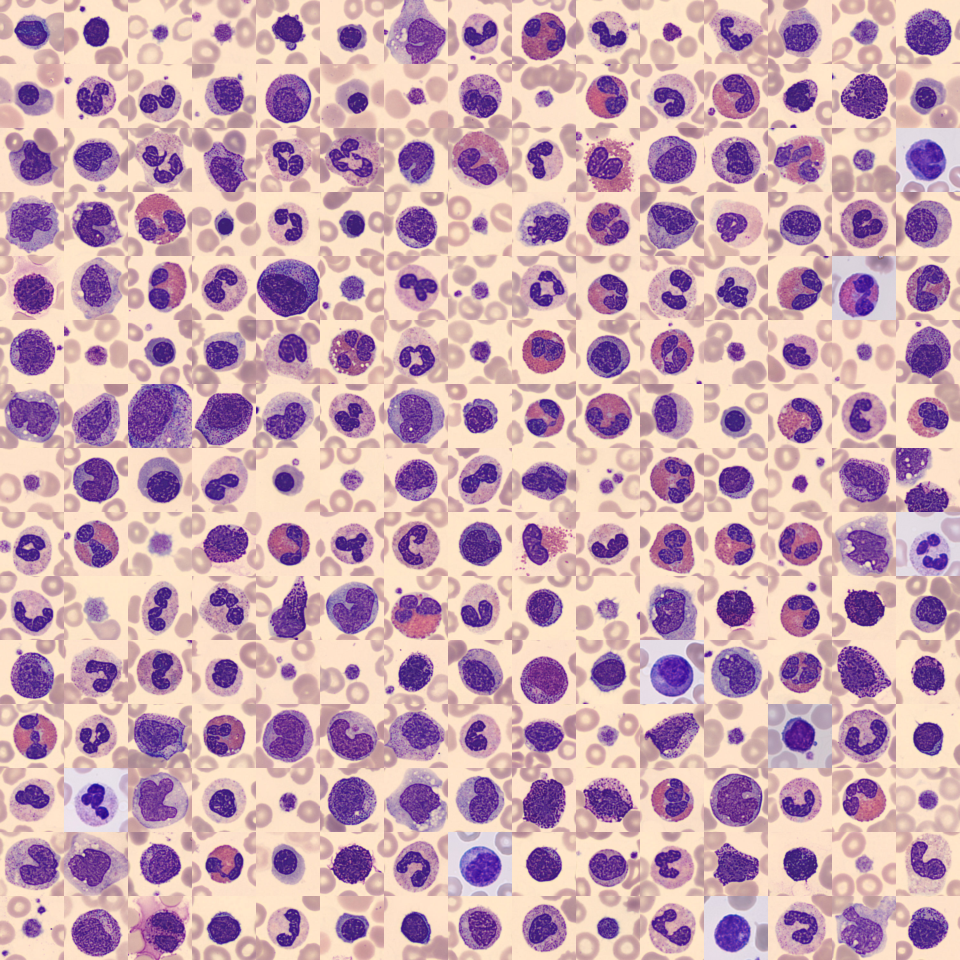

In [222]:
train_dataset.montage(length=15)

In [234]:
from torchvision import models, datasets, transforms
densenet121 = models.densenet121(pretrained=True)
densenet121.eval() # set the model to evaluation model
pass

In [235]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
densenet121.classifier = Identity()


In [239]:
# Training Function
def train_densenet(model, train_loader, val_loader, task, num_epochs, lr):
    model = model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    # Choose loss function based on the task type
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss().to(device)
    else: # multi-class
        criterion = nn.CrossEntropyLoss().to(device)
    output_layer = nn.Linear(1024, 8, bias = True).to(device)
    optimizer = optim.SGD(output_layer.parameters(), lr=lr, momentum=0.9)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = output_layer(model(images).detach())
            
            if task == "multi-label, binary-class":
              labels = labels.to(torch.float32)  # Ensure float for BCEWithLogitsLoss
            else: # multi-class
              labels = labels.squeeze().long() # Convert one-hot to class index

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if task == "multi-label, binary-class":
                outputs = torch.sigmoid(outputs)
                predicted = (outputs >= 0.5).long()
                correct += torch.eq(predicted, labels).sum().item()
                total += labels.numel() # Nombre total d'éléments (batch_size * classes)
            else:
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
            


        accuracy = 100 * (correct / total)
        train_losses.append(running_loss / total)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/total:.4f}, Accuracy: {accuracy:.2f}%")


        # Validation phase
        model.eval()  # Set model to evaluation mode (disables dropout, batchnorm, etc.)
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # No need to compute gradients for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if task == "multi-label, binary-class":
                  labels = labels.to(torch.float32)  # Ensure float for BCEWithLogitsLoss
                else:
                  labels = labels.squeeze().long() # Convert one-hot to class index

                loss = criterion(outputs, labels)

                val_loss += loss.item() 

                if task == "multi-label, binary-class":
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs >= 0.5).long()
                    val_correct += torch.eq(predicted, labels).sum().item()
                    val_total += labels.numel()
                else:
                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)

            
        # Compute validation accuracy
        val_accuracy = 100 * (val_correct / val_total)
        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/ total:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_losses, val_accuracies


Let's try to train the last layer of densenet.

In [240]:
NUM_EPOCHS = 10
trained_model, train_losses, val_losses, val_accuracies = train_densenet(densenet121, train_loader, val_loader, task, NUM_EPOCHS, lr)

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [01:37<00:00,  8.11s/it]


Epoch 1/10, Loss: 0.0021, Accuracy: 19.48%
Epoch 1/10, Val Loss: 0.0016, Val Accuracy: 0.00%


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [01:36<00:00,  8.05s/it]


Epoch 2/10, Loss: 0.0016, Accuracy: 49.01%
Epoch 2/10, Val Loss: 0.0017, Val Accuracy: 0.00%


  8%|███████                                                                             | 1/12 [00:16<02:59, 16.32s/it]


KeyboardInterrupt: 

This is overfitting. Let's try to see what densenet detects at the earlier layers.

In [242]:
densenet121 = densenet121.cpu()
img, losses = activation_maximization(densenet121, 0, 0, lr = 1, n_iters = 1000, tau = 1e-3)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


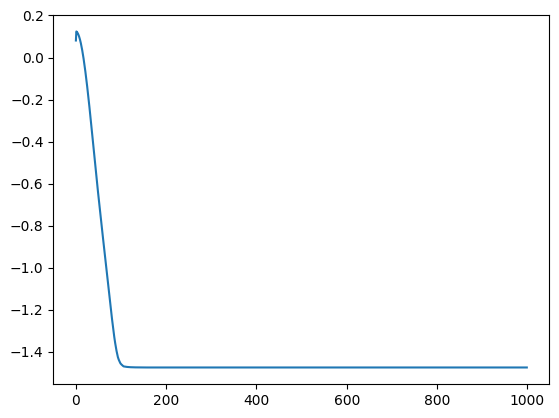

In [246]:
plt.plot(losses)

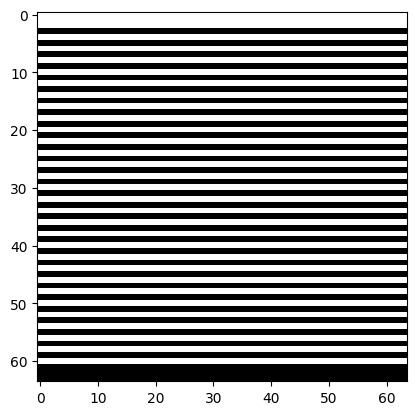

In [244]:
plt.imshow(img[:, :])

It seems like this layer detects horizontal lines.